In [1]:
#general import
import os
import numpy as np
import pandas as pd

#nn import
from torch import device, load

#stats import
from scipy.stats import ttest_rel, wilcoxon
from statistics import median
from statsmodels.stats import multitest

#general visualization import
#import seaborn as sns
from matplotlib import pyplot as plt
#from matplotlib import gridspec, colors, colormaps

#brain visualization import
from nilearn import regions, datasets, surface, plotting, image
from nilearn.plotting import plot_roi, plot_stat_map

#package import (for class) --> TO CHANGE
import sys
#sys.path.append('/home/maelle/GitHub_repositories/cNeuromod_encoding_2020')  b

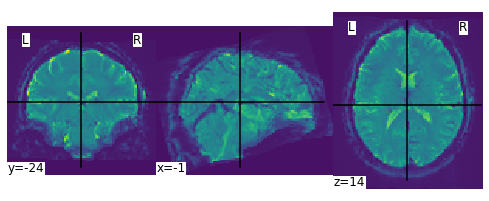

In [10]:
path = '/lustre03/project/rrg-pbellec/maellef/finefriends/data/friends.fmriprepcd/sub-01/ses-001/func/'
file = 'sub-01_ses-001_task-s01e02a_space-T1w_desc-preproc_bold.nii.gz'
file2 = 'sub-01_ses-001_task-s01e02a_space-MNI152NLin2009cAsym_boldref.nii.gz'

output_path = '/home/maellef/projects/def-pbellec/maellef/data'
filepath = os.path.join(path, file)
filepath2 = os.path.join(path, file2)

outfile = os.path.join(output_path, file)
outfile2 = os.path.join(output_path, file2)

img = image.load_img(filepath)
img2 = image.load_img(filepath2)

plotting.plot_img(img2)
img2.to_filename(outfile2)

In [21]:
out_path = '/home/maelle/Results/figures/surface'
r2_test_model_path = '/home/maelle/Results/best_models'
r2_by_run_path = '/home/maelle/Results/best_models/predict_S4_runs'
MIST_path = '/home/maelle/DataBase/fMRI_parcellations/MIST_parcellation/Parcellations/MIST_ROI.nii.gz'
voxel_mask = '/home/maelle/GitHub_repositories/cNeuromod_encoding_2020/parcellation/STG_middle.nii.gz'
mist_roi_labels = '/home/maelle/DataBase/fMRI_parcellations/MIST_parcellation/Parcel_Information/MIST_ROI.csv'
#---------------------------------------------------------------------------
background_path = '/home/maelle/Results/ref_anat'
background_file = ['MNI152NLin6Asym_desc-preproc_T1w.nii.gz']


label_pd = pd.read_csv(mist_roi_labels, sep=';')
print(label_pd.columns)

subs = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06']
scale = 'MIST_ROI'#'auditory_Voxels'  
conv = 'conv4'
baseline = 'no_ft'
null_model = 'no_init'
diff_name = '{}-{}'.format(conv, baseline)

colormap = {
    'R_STgyr_m':'darkmagenta',
    'L_STgyr_m':'palevioletred',
    'R_STgyr_p':'maroon',
    'L_STgyr_p':'tomato',
    #'R_MTgyr_p':'chocolate',
    'L_MTgyr_p':'orange',
    'R_HSgyr':'goldenrod',
    'L_HSgyr':'gold',
    'R_VVISnet_l':'darkgreen',
    #'L_VVISnet_l':'palegreen',
    #'R_PVISnet_l' : 'darkcyan',
    'L_PVISnet_l' : 'turquoise',
    'R_LVISnet_DP':'darkblue',
    'L_LVISnet_DP':'mediumslateblue'
}

Index(['roi', 'label', 'name', 'size', 'symmetry', 'laterality', 'x', 'y', 'z',
       'neighbour', 'parent', 'overlap'],
      dtype='object')


In [3]:
def list_positions_in_matrix2D(nb_rows, nb_col):
    i_rows = np.repeat(np.arange(nb_rows), nb_col)
    i_col = np.tile(np.arange(nb_col), nb_rows)
    pos = [(row, col) for row, col in zip(i_rows, i_col)]
    return pos

In [4]:
def sum_conditions(conditions) : 
    correct = True
    for condition in conditions:
        if condition == False:
            correct = False
            break
    return correct

In [5]:
def get_specific_file_path(path, *cond):
    specific_file_path = None
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        conditions = [(obj in file) if boolean else (obj not in file) for (obj, boolean) in cond]
        specific_file = sum_conditions(conditions)
        specific_file_path = filepath if specific_file else specific_file_path
    return specific_file_path

In [6]:
def n_best_rois(data, n, columns_label = label_pd['label']):
    runs_df = pd.DataFrame(data, columns=columns_label)  
    median_runs_df = runs_df.median().sort_values(ascending=False)
    best_n_roi = list(median_runs_df.head(n).index)

    return best_n_roi

In [7]:
def df_runs_from_list(data, list_roi, sub, columns_label = label_pd['label']):
    runs_df = pd.DataFrame(data, columns=columns_label)
    all_runs_df = runs_df.melt(var_name = 'roi', value_name='r2', ignore_index=False)
    best_runs = all_runs_df.loc[(all_runs_df['roi'].isin(list_roi))].copy()
    best_runs['subject'] = sub

    return best_runs

In [8]:
def voxels_nii(voxel_data, voxel_mask, t_r=1.49):
#from voxels to nii
    voxel_masker = maskers.NiftiMasker(mask_img=voxel_mask, standardize=False, 
                                       detrend=False, t_r=t_r, smoothing_fwhm=8)
    voxel_masker.fit()
    vox_data_nii = voxel_masker.inverse_transform(voxel_data)
    return vox_data_nii

In [9]:
def brain_with_cuts(axe = 'sagittal', axe_slice = 50, cut_x = [], cut_y = [], cut_z = [], ax=None):
    brain = datasets.load_mni152_template()
    brain_arr = image.get_data(brain)
    
    #select the array
    if axe == 'x' or axe == 'sagittal':
        brain_slice = brain_arr[axe_slice,:,:].squeeze()
        cuts = [cut_y, cut_z]
    elif axe == 'y' or axe == 'coronal':
        brain_slice = brain_arr[:,axe_slice,:].squeeze()
        cuts = [cut_x, cut_z]
    elif axe == 'z' or axe == 'axial':
        brain_slice = brain_arr[:,:,axe_slice].squeeze()
        cuts = [cut_x, cut_y]
    else : 
        raise ValueError('the axe of the brain slice {} does not exist'.format(axe))
    
    #remove noise + black background
    brain_slice[brain_slice < 10**-10] = 0
    brain_slice[brain_slice == 0.0] = 1
    
    #add the cut in the array
    print(cuts)
    for cut in cuts[0] : 
        brain_slice[cut, :] = 0
    for cut in cuts[1] : 
        brain_slice[:, cut] = 0
    
    brain_slice = np.flip(brain_slice.T, axis=0)
    
    if ax is not None:
        ax.imshow(brain_slice, cmap='gray')
    else : 
        plt.imshow(brain_slice, cmap='gray')

In [10]:
def stats_between_pop(pop1, pop2, test = ttest_rel, threshold = 0.05, difference=False):
    sign_diff_rois = []
    for i, (pop1_roi, pop2_roi) in enumerate(zip(pop1, pop2)):
        if difference :
            pop1_roi = pop1_roi - pop2_roi
            pop2_roi = None
        stat, pvalue = test(pop1_roi, pop2_roi)
        if pvalue <= threshold :
            sign_diff_rois.append((i, pvalue))
    return sign_diff_rois

def stats_between_pop2(pop1, pop2, test = ttest_rel, threshold = 0.05, difference=False):
    sign_diff_rois = []
    all_diff_rois = []
    for i, (pop1_roi, pop2_roi) in enumerate(zip(pop1, pop2)):
        if difference :
            pop1_roi = pop1_roi - pop2_roi
            pop2_roi = None
        stat, pvalue = test(pop1_roi, pop2_roi)
        all_diff_rois.append((i, pvalue))
        if pvalue <= threshold :
            sign_diff_rois.append((i, pvalue))
    return (all_diff_rois, sign_diff_rois)

In [11]:
def best_rois_in_MIST_array(data_array, nb_occ=3):
    a = np.unique(np.argmax(data_array, axis=1), return_counts=True)
    nb_i = [(i, nb, label_pd['label'].iloc[i]) for i, nb in zip(a[0], a[1]) if nb>=nb_occ]
    return nb_i

In [12]:
def voxel_map(voxel_data, vmax=None, cut_coords=None, tr = 1.49, bg_img=None, cmap = 'cold_hot') : 
    f = plt.Figure()
    data_nii = voxels_nii(voxel_data, voxel_mask, t_r=tr)
    if bg_img is not None : 
        plotting.plot_stat_map(data_nii, bg_img=bg_img, draw_cross=False, vmax=vmax,
                           display_mode='x', cut_coords=[-63, -57, 57, 63], figure=f,
                              black_bg=True, dim = 0, cmap=cmap)
    else :
        plotting.plot_stat_map(data_nii, draw_cross=False, vmax=vmax,
                           display_mode='x', cut_coords=[-63, -57, 57, 63], figure=f)
    return f

In [13]:
def surface_fig(parcel_data, vmax, threshold=0.05, cmap='turbo', inflate=True, colorbar=True):
    nii_data = regions.signals_to_img_labels(parcel_data, MIST_path)
    fig, ax = plotting.plot_img_on_surf(nii_data,
                              views=['lateral', 'medial'], hemispheres=['left', 'right'], inflate=inflate,
                              vmax=vmax, threshold=threshold, colorbar=colorbar, cmap=cmap, symmetric_cbar=False)
    return fig

In [14]:
def extend_colormap(original_colormap = 'twilight', percent_start = 0.25, percent_finish = 0.25):
    colormap = colormaps[original_colormap]
    nb_colors = colormap.N
    new_colors_range = colormap(np.linspace(0,1,nb_colors))

    n_start = round(nb_colors/(1-percent_start)) - nb_colors if percent_start != 0 else 0
    new_color_start = np.array([colormap(0)]*n_start).reshape(-1, new_colors_range.shape[1])
    n_finish = round(nb_colors/(1-percent_finish)) - nb_colors if percent_finish != 0 else 0
    new_color_finish = np.array([colormap(0)]*n_finish).reshape(-1, new_colors_range.shape[1])

    new_colors_range = np.concatenate((new_color_start,new_colors_range,new_color_finish), axis=0)
    new_colormap = colors.ListedColormap(new_colors_range)
    return new_colormap

sub-01
69
sub-01_space-MNI152NLin6Asym_desc-preproc_T1w.nii.gz
sub-02
30
sub-02_space-MNI152NLin6Asym_desc-preproc_T1w.nii.gz
sub-03
45
sub-03_space-MNI152NLin6Asym_desc-preproc_T1w.nii.gz
sub-04
77
sub-04_space-MNI152NLin6Asym_desc-preproc_T1w.nii.gz
sub-05
24
sub-05_space-MNI152NLin6Asym_desc-preproc_T1w.nii.gz
sub-06
0
sub-06_space-MNI152NLin6Asym_desc-preproc_T1w.nii.gz


/home/maelle/virtualenv/visu/lib/python3.7/site-packages/nilearn/image/image.py:756: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
  return klass(data, affine, header=header)


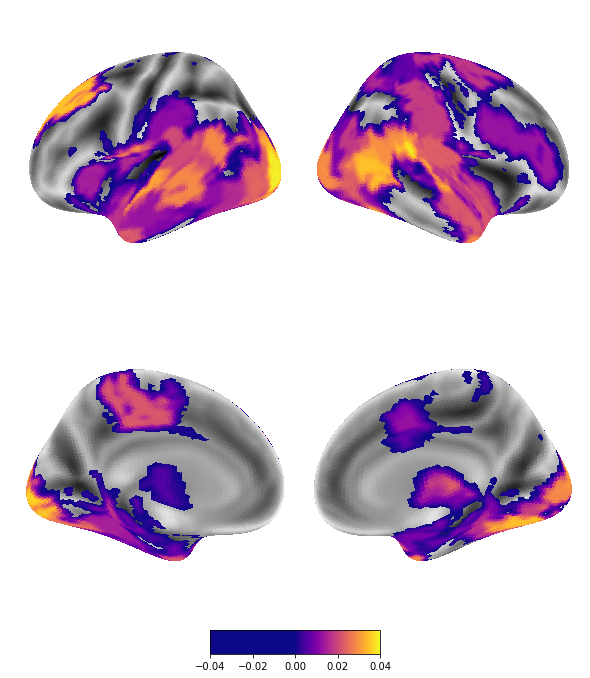

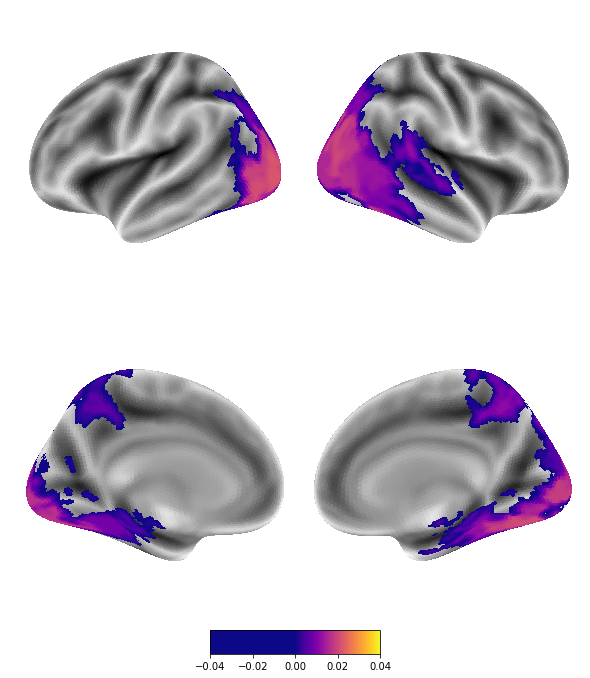

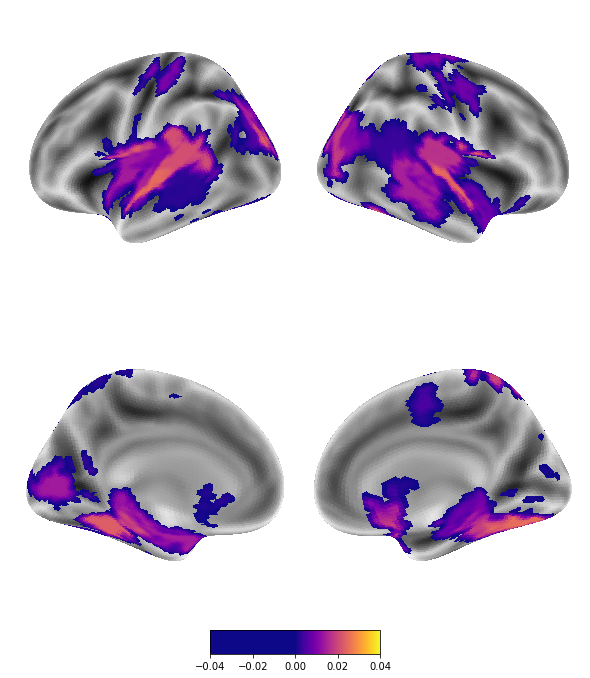

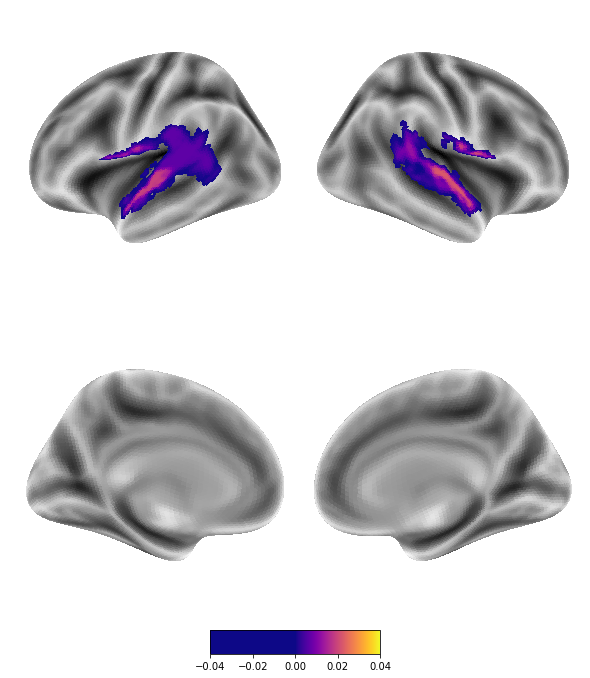

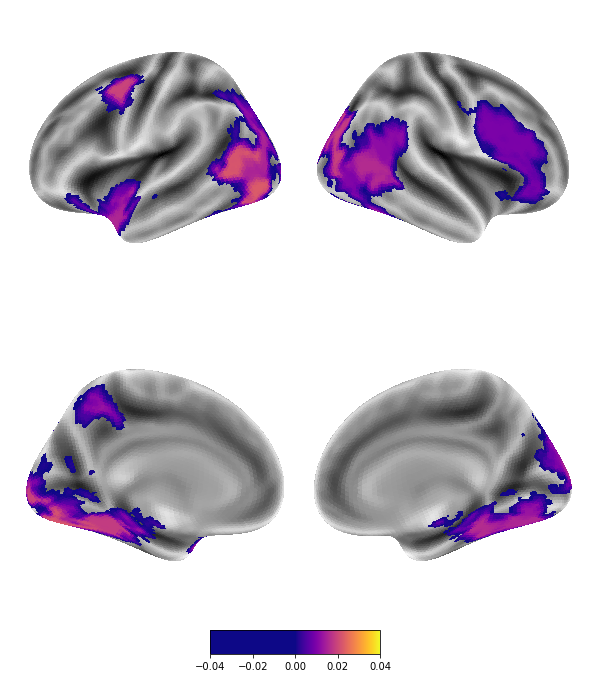

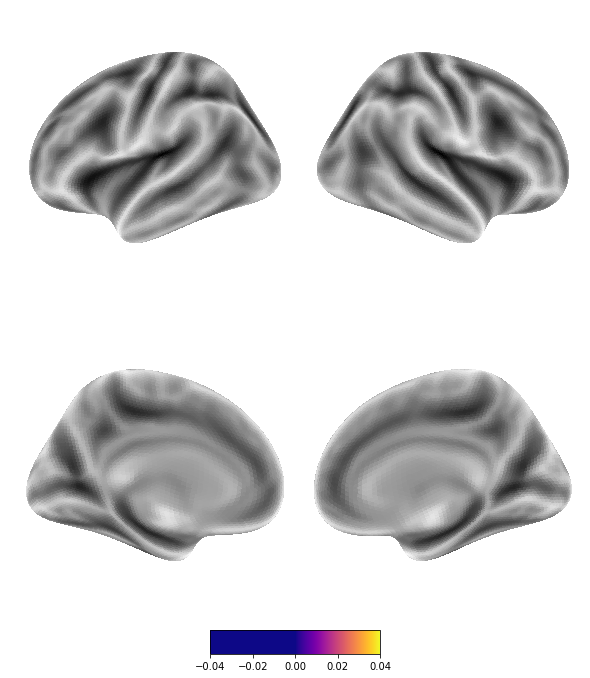

In [23]:
#MAIN CODE - to refine
#produce surface figures + extract data
#=============================================================

#change args
cmp = extend_colormap(original_colormap = 'plasma', percent_start=0.5, percent_finish=0) 
#turbo ou YlGn_r

subs_data = {}

for sub in subs :  
    #fig = plt.figure(figsize=(7,10))
    #spec = fig.add_gridspec(ncols=2, nrows=1)
    #ax = fig.add_subplot(spec[0, 0])
    #legend_ax = fig.add_subplot(spec[0, 1:])
    print(sub)
    
    #r² scores for each run of Friends S4
    run_conv_file_path = get_specific_file_path(r2_by_run_path, (sub, True),(scale, True),(conv, True))
    run_baseline_file_path = get_specific_file_path(r2_by_run_path, (sub, True),(scale, True),('_f_', False))
    run_null_file_path = get_specific_file_path(r2_by_run_path, (sub, True),(scale, True),(null_model, True))
    run_conv_data = np.load(run_conv_file_path)
    run_baseline_data = np.load(run_baseline_file_path) 
    run_null_data = np.load(run_null_file_path)
    diff_conv_bas_runs = run_conv_data - run_baseline_data

    #r² score from test after training
    test_path = os.path.join(r2_test_model_path, sub)
    test_conv_file_path = get_specific_file_path(test_path,(scale, True),(conv, True))
    test_conv_data = load(test_conv_file_path, map_location=device('cpu'))['test_r2']
    test_baseline_file_path = get_specific_file_path(test_path,(scale, True),('_f_', False))
    test_baseline_data = load(test_baseline_file_path, map_location=device('cpu'))['test_r2']
    diff_conv_bas_data = test_conv_data - test_baseline_data
    
    subs_data[sub] = run_baseline_data
    
    #statistical tests
    #------------------change args !!!--------------
    all_region, sign_region = stats_between_pop2(run_conv_data.T, run_baseline_data.T, test = wilcoxon, 
                                    threshold=0.05, difference = True)    
    #FDR correction
    p_values = [p_val for i, p_val in all_region]
    rejected, p_vals_corr = multitest.fdrcorrection(p_values, method='n')
    sign_fdr = [(i, p_val) for i, (p_val, sign) in enumerate(zip(p_vals_corr, rejected)) if sign]
    print(len(sign_fdr))
    
    #keep only roi with significative differences (others are set at 0)    
    idx_sign_roi = [idx for idx, p_value in sign_fdr]
    #------------------change args !!!--------------
    runs_mean = np.mean(diff_conv_bas_runs, axis=0)
    a = [value if i in idx_sign_roi else 0 for i, value in enumerate(runs_mean)]
    a = [value if value>0 else 0 for value in a]
    sign_test_data = np.array(a).reshape(1,-1)  

    #surface map
    threshold = 0.0001
    colorbar = True
    n = 7
    cut_coords = [-63, -57, 57, 63]
    
    bg_img = ''
    for bg_img in background_file : 
        for filename in os.listdir(background_path):
            if (sub in filename) & (bg_img in filename) :  
                bg_name = filename 
            else : 
                pass
        
        print(bg_name)
        bg_path = os.path.join(background_path, bg_name)
        output_file = os.path.join(out_path, 'WB_diff_pos_map_fdrby_runs_{}.png'.format(sub))
        
        #add your fig code
        fig = surface_fig(sign_test_data, vmax=0.04, threshold=threshold, colorbar=colorbar, cmap=cmp) #vmax=0.4
        fig.set_size_inches(8,10)
        fig.savefig(output_file, dpi=100)

    #surface maps
    
    #fig = voxel_map(sign_test_data, vmax = 0.5, bg_img=bg_path) #cmap = cmp, vmax = 0.06
    #fig.set_size_inches(28,3)
    #fig = surface_fig(sign_test_data, vmax=vmax, threshold=threshold, colorbar=colorbar, cmap=cmp) 
    #fig.set_size_inches(8,10)
    
    #stripplot with order of ROIs in WB maps
    
    #best_n_roi, best_runs = df_runs_from_n_best_roi(run_baseline_data, n=n)
    #striplot_with_median(data = best_runs, x= 'subject', y='r2', hue = 'roi', hue_order = best_n_roi, palette=colormap, ax=ax)
    #fig.savefig(output_file, dpi=100)
    

In [ ]:
#is it really useful as a function ?

def striplot_with_median(data, x, y, hue, hue_order, palette, ax, legend_ax, join = False):
    sns.stripplot(data = data, x=x, y=y, hue = hue, hue_order = hue_order, palette=palette,
                  dodge = True, jitter = True, alpha=0.2, ax=ax)
    sns.pointplot(data = data, x=x, y=y, hue = hue, hue_order = hue_order, palette=palette,
                  estimator=median, join = join, errorbar=('ci', 95), errwidth=1, markers='D', ax=ax,
                  scale=0.75, dodge = .85 - .85 / 7)
    ax.set_ylim(-0.15, 0.5)
    ax.legend([])
    ax.hlines(y=0, xmin = -0.4, xmax = 0.4, linewidth=1, color='grey', linestyles='dotted')
    
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in palette.values()]
    legend_ax.legend(markers, palette.keys(), numpoints=1, bbox_to_anchor=(1,1))
    legend_ax.set_axis_off()

In [ ]:
#baseline stripplot with median
#============================================================================
rois = list(colormap.keys())
median_df = pd.DataFrame()
for sub in subs : 
    data = subs_data[sub]
    runs_df = pd.DataFrame(data, columns=label_pd['label'])  
    median_runs_df = runs_df.median().sort_values(ascending=False)
    rois_df = median_runs_df.loc[rois]
    rois_df.name = sub
    median_df = pd.concat([median_df, rois_df], join='outer', axis=1)
mean_median = median_df.mean(axis=1).sort_values(ascending=False)
rois_order = list(mean_median.index)
print(rois_order)

for sub in subs : 
    data = subs_data[sub]
    fig = plt.figure(figsize=(7,10))
    spec = fig.add_gridspec(ncols=2, nrows=1)
    ax = fig.add_subplot(spec[0, 0])
    legend_ax = fig.add_subplot(spec[0, 1:])

    best_n_roi = n_best_rois(data, n)
    best_runs = df_runs_from_list(data, rois_order, sub)    
    sub_colormap = {roi : color if roi in best_n_roi else 'grey' for roi, color in colormap.items()}

    striplot_with_median(data = best_runs, x= 'subject', y='r2', 
                         hue = 'roi', hue_order = rois_order, palette=colormap, 
                         ax=ax, legend_ax=legend_ax)
    output_file = os.path.join(out_path, 'test_striplot_full_color_{}.png'.format(sub)) 
    fig.savefig(output_file, dpi=100)
        

In [ ]:
#striplot_with_median(data, x, y, hue, hue_order, palette, ax)
#==================================================================================

#best_rois_in_MIST_array(data_array, nb_occ=3)25
all_sub_runs_df = pd.DataFrame(columns=['roi', 'subject', 'conv','diff_r2', 
                                        'side', 'data type'])
roi_order = [
    'STgyr_m',
    'STgyr_p',
    'MTgyr_p',
    'HSgyr',
    'VVISnet_l',
    'PVISnet_l',
    'LVISnet_DP',
        ]

red = np.array([255, 0, 0])
sub1 = np.array([255, 204, 255])
sub2 = np.array([204, 204, 255])
sub3 = np.array([204, 255, 255])
sub4 = np.array([204, 255, 204])
sub5 = np.array([255, 255, 204])
sub6 = np.array([255, 229, 204])

newcmp = ['black', 'dimgrey', 'grey', 'darkgray', 'silver', 'gainsboro','red']

for sub in subs:  
    #r² score from test after training
    r2_path = r2_by_run_path
        
    run_baseline_file_path = get_specific_file_path(r2_by_run_path, (sub, True),(scale, True),('_f_', False))
    run_baseline_data = np.load(run_baseline_file_path)
    #rois = n_best_rois(run_baseline_data, n=7)
    rois = list(colormap.keys())
    rois.extend(['R_MTgyr_p', 'L_VVISnet_l', 'R_PVISnet_l'])
    
    basl_runs = df_runs_from_list(run_baseline_data, list_roi=rois, sub=sub)
    df_runs = basl_runs.rename(columns={'r2':'r2_basl'})
    
    for conv in ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'] :
        r2_conv_file_path = get_specific_file_path(r2_path, (sub, True), (scale, True),(conv, True))
        r2_conv_data = np.load(r2_conv_file_path)
        conv_runs = df_runs_from_list(r2_conv_data, list_roi=rois, sub=sub)
        
        df_runs[conv] = conv_runs['r2'] - df_runs['r2_basl']
    df_runs = df_runs.drop(labels='r2_basl', axis=1)
    df_runs = df_runs.melt(id_vars=['roi', 'subject'], var_name='conv', value_name='diff_r2')
    df_runs['data type'] = 'individual'
    all_sub_runs_df = pd.concat([all_sub_runs_df, df_runs], axis=0, ignore_index=True)

all_sub_runs_df.loc[all_sub_runs_df['roi'].str.contains('L_',case=True), 'side'] = 'left'
all_sub_runs_df.loc[all_sub_runs_df['roi'].str.contains('R_',case=True), 'side'] = 'right'
all_sub_runs_df['roi'] = all_sub_runs_df['roi'].str.replace('L_', '', n=1)
all_sub_runs_df['roi'] = all_sub_runs_df['roi'].str.replace('R_', '', n=1)

mean_df = all_sub_runs_df.groupby(by=['roi', 'conv', 'side'], axis=0).mean()
mean_df = mean_df.reset_index()
mean_df['subject'] = 'mean'
mean_df['data type'] = 'mean'
all_sub_runs_df = pd.concat([all_sub_runs_df,mean_df], axis=0, ignore_index=True)

print(all_sub_runs_df)

#sns.set(rc={'axes.facecolor':'lightseagreen', 'axes.grid': False})
sns.set_context("poster")
a = sns.relplot(data=all_sub_runs_df, x='conv', y='diff_r2', err_style = 'band', ci=None,
                col='roi', col_order = roi_order, row = 'side', row_order = ['right', 'left'], 
                hue="subject",kind="line", 
                style = 'data type', style_order=['individual','mean'], size='data type', sizes=[3,6], 
                palette=newcmp, facet_kws = {'sharex':True,'sharey':False,})

output_file = os.path.join(out_path, 'all_subs_graph_finetune_r2_.png'.format(sub))
plt.savefig(output_file, dpi=100)

In [ ]:
#Research on colormap for brain parcellation of specific rois - 1
#=================================================================================

def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()
    
nb_colors = 210
window_size = 2
rois = [75, 103, 141, 152, 170, 204]

my_colors = ['indianred', 'navajowhite', 'gold', 'darkseagreen', 'mediumslateblue', 'palevioletred']
my_listedcolormap = []
for i, (roi, roi_color) in enumerate(zip(rois, my_colors)) :
    color_RGBA = colors.to_rgba(roi_color)
    
    previous_roi = rois[i-1] + window_size + 1 if i != 0 else 0
    previous_window_len = roi - window - previous_roi
    previous_window = [(0.0,0.0,0.0,0.0)]*previous_window_len if (roi - window) > 0 else []
    my_listedcolormap.extend(previous_window)
    
    window_len = window + 1
    colored_window = [color_RGBA]*window_len
    window_end = roi + window + 1
    
    if i == nb_colors-1:
        end_window = [(0.0,0.0,0.0,0.0)]*(nb_colors - roi + window) if (roi - window) > 0 else []
    
    window = []
        
        
    
    print(roi, roi_color, roi_window, color_RGBA)

In [ ]:
#Research on colormap for brain parcellation of specific rois - 2
#=======================================================================================

roi_labels = list(colormap.keys())
for side in ['L', 'R']:
    roi_labels_side = [label for label in roi_labels if label[0] == side]
    roi_index = [i for i, row in label_pd.iterrows() if row['label'] in roi_labels_side]
    colors_side = [color for key, color in colormap.items() if key in roi_labels_side]
    
    parcel_data = np.zeros((1, 210))
    for roi in roi_index:
        parcel_data[:,roi] = roi
    print(roi_labels_side, roi_index, colors_side)

    fsaverage = datasets.fetch_surf_fsaverage()
    mesh = fsaverage.infl_right if side == 'R' else fsaverage.infl_left
    bg_map=fsaverage.sulc_right if side == 'R' else fsaverage.sulc_left
    pial = fsaverage.pial_right if side == 'R' else fsaverage.pial_left
    
    nii_data = regions.signals_to_img_labels(parcel_data, MIST_path)
    parcellation = surface.vol_to_surf(nii_data, pial, interpolation='nearest')
    parcellation = np.ceil(parcellation)
    print(np.unique(parcellation))
    
    hemi = "left" if side == 'L' else "right"
    plotting.plot_surf_roi(mesh, parcellation, hemi=hemi, view="lateral", bg_map=bg_map) #bg_on_data=True)
    
    plotting.show()

In [ ]:
#produce a brain figure with slices to represent the cut
#=====================================================================================

z=36
cuts_x = [80, 18,20,78]

for cut_x in cuts_x:
    fig, ax = plt.subplots(1,1)
    cut_x = [cut_x]
    brain_with_cuts(axe='axial', axe_slice=z, cut_x=cut_x, ax=ax)
    ax.set_axis_off()
    fig.savefig(os.path.join(out_path, 'brain_cuts_STG_{}.jpg'.format(cut_x)), dpi=100)
    plt.close()

In [ ]:
#==============TRASH ?==================================================================
#options to create figures ? 
fig = plt.figure()
spec = fig.add_gridspec(ncols=2, nrows=1)
axe = fig.add_subplot(spec[0, 0])
legend_ax = fig.add_subplot(spec[0, 1])

ymin = -0.025
ymax = 0.06 #if sub == 'sub-03' else 0.04
axe.set_ylim(ymin, ymax)
axe.legend([])
axe.hlines(y=0, xmin = -0.5, xmax = 6.5, linewidth=1, color='grey', linestyles='dotted')
axe.vlines(x=3, ymin = ymin, ymax = ymax, linewidth=1, color='grey', linestyles='dotted')
axe.tick_params(rotation = 45)
axe.set_xlabel(sub)
axe.set_ylabel('r² score difference between baseline and conv')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colormap.values()]
legend_ax.legend(markers, colormap.keys(), numpoints=1, bbox_to_anchor=(1,1))
legend_ax.set_axis_off()
